In [11]:
import pandas as pd
import numpy as np

df= pd.read_csv('Brazil_olist_이커머스데이터(기본전처리).csv', index_col=0)
df.head()

,고객_유니크id,고객_도시,고객_주(state),주문id,주문상태,구매시간,주문승인일,배송시작일,배송일,예상배송일,...,결제금액_usd,운임가격_usd,고객_판매자_거리_km,구매count,배송지연시간,주문처리시간,배송소요시간,전체물류처리시간,리뷰답변_처리속도,category_대분류
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,...,46.040752,6.858934,348.770656,1,-11.0,0,1.0,8.0,4,가구/인테리어
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,...,86.454545,7.805643,2506.927836,1,-21.0,0,5.0,17.0,2,가구/인테리어
2,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12,...,44.078370,4.896552,860.018003,1,-17.0,1,6.0,17.0,1,가구/인테리어
3,567ab47ca4deb92d46dbf54dce07d0a7,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,2017-04-11 10:16:56,2017-04-24,...,44.529781,4.721003,525.701996,1,-13.0,0,13.0,18.0,3,가구/인테리어
4,f40ab89b622248b7ca125af4b486b887,contagem,MG,e0b26f14d2bcc710bb02f77a4628763b,delivered,2017-05-16 10:00:49,2017-05-17 03:45:27,2017-05-23 10:35:48,2017-05-29 12:04:19,2017-06-07,...,48.808777,9.626959,461.801509,1,-9.0,0,6.0,12.0,1,가구/인테리어


In [12]:
# 코호트 함수

from pandas import Series
from pandas import DataFrame
 
import matplotlib.pyplot as plt
import seaborn as sns
 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


def make_cohort_chart(co):
    
    co['date'] = pd.to_datetime(co['date'])

    co['구매주기'] = co['date'].dt.strftime('%Y.%m') # 월단위로 ?

    ### 코호트 분석에 필요한 변수 생성
    # 고객별 첫 구매가 언제 이뤄졌는지 파악하기 -> 그뒤 고객 첫 구매데이터를 df 에 붙이기
    first_order = co.groupby('고객_유니크id')['date'].min()
    first_order = first_order.dt.strftime('%Y.%m')

    co = co.set_index('고객_유니크id')
    co['첫구매'] = first_order
    co.reset_index(inplace = True)
    
    ## 월별로 구매 고객 데이터 치환해보기
    ## 주기별 구매 User 계산
    co1 = co.groupby(['첫구매', '구매주기'])['고객_유니크id'].nunique()
    co1 = co1.reset_index()
    co1.rename({'고객_유니크id': '총고객'}, axis = 1, inplace = True)
    
    
    ## 주기별 구매 금액 계산
    co2 =co.groupby(['첫구매', '구매주기'])['결제금액_usd'].sum()
    co2 = co2.reset_index()
    co2.rename({'결제금액_usd': '총 구매'}, axis = 1, inplace = True)
    
    
    ## 데이터의 병합
    co = co1.merge(co2, on = ['첫구매', '구매주기'])
    co.head()

    ### 코호트를 첫구매월로 한거지?

    from tqdm import tqdm
    temp = []
    
    for i in tqdm(range(co.shape[0])):
        f_first_order = pd.to_datetime(co['첫구매'][i]).to_period('M')
        f_order_cycle = pd.to_datetime(co['구매주기'][i]).to_period('M')
        
        month_diff = (f_order_cycle - f_first_order).n
        
        temp.append(month_diff)
    co['CohortPeriod'] = temp

    ## 첫 번째. 재방문율 계산을 위한 Pandas Unstack 활용
    co_retention = co.set_index(['첫구매', 'CohortPeriod'])
    co_retention = co_retention['총고객'].unstack(1)
    retention = co_retention.div(co_retention[0],axis = 0)
    
    
    ## 두 번째. 구매 규모 형태 치환을 위한 Pandas Unstack 활용
    co_purchase = co.set_index(['첫구매', 'CohortPeriod'])
    co_purchase = co_purchase['총 구매'].unstack(1)
    
    plt.rcParams['figure.figsize'] = (15, 12) 
    sns.heatmap( retention ,  annot = True, fmt = '.1%')

# 1) 상황파악 (EDA) & 문제정의

## 상황 

- 확인한 주요 지표 : 매출 , 주문량, 이탈률 등
- 이탈률: 96% / 재구매율 : 4% 

- 코호트 분석 결과: 코호트별 재구매율이 모두 1% 미만






## 문제 정의

- (문제) 월별 분기별 매출은 증가 추세지만 재구매율은 4% 미만으로 꾸준히 낮음.

- (해결 방안) ∴ 고객 이탈 원인을 분석해 초기 구매 경험 (배송, 제품 품질 등)이 이탈에 미친 영향을 파악하고, 재구매율을 높이는 방안을 도출합니다.  
    - 신규 고객 의존으로 매출 상승 유지 구조는 지속 가능성이 떨어지기 때문.
    - ( 고객 획득 비용 증가 (CAC), 매출 안정성 부족,  고객 충성도 부족, 고객 이탈률 증가  , 브랜드 신뢰도 및 평판 저하 )



 

 





In [14]:
# 분기별 매출은 점차 증가 추세 

import pandas as pd
import plotly.graph_objects as go
import numpy as np

import pandas as pd
import plotly.express as px

D = pd.DataFrame(df.groupby(['quarter'])['결제금액_usd'].sum()).reset_index()


# 숫자형 분기 생성
D['quarter_num'] = range(1, len(D) + 1)

# 추세선 계산
z = np.polyfit(D['quarter_num'], D['결제금액_usd'], 1)  # 1차 추세선
p = np.poly1d(z)

# 추세선 추가
D['trend'] = p(D['quarter_num'])

# 그래프 생성
fig = go.Figure()

# 분기별 매출 라인
fig.add_trace(go.Scatter(x=D['quarter'], y=D['결제금액_usd'], mode='lines+markers', name='결제금액_usd'))

# 추세선
fig.add_trace(go.Scatter(x=D['quarter'], y=D['trend'], mode='lines', name='추세선', line=dict(dash='dot', color='red')))

# 그래프 레이아웃 설정
fig.update_layout(
    title='분기별 매출 변화 추세 (2017~2018 3Q)',
    xaxis_title='Quarter',
    yaxis_title='결제금액 (USD)',
    template='plotly_white'
)

# 그래프 표시
fig.show()


In [15]:
# 분기별 매출은 점차 증가 추세 

import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly.express as px


D = pd.DataFrame(df.groupby(['year_month'])['결제금액_usd'].sum()).reset_index() 

# 숫자형 분기 생성
D['year_month_num'] = range(1, len(D) + 1)

# 추세선 계산
z = np.polyfit(D['year_month_num'], D['결제금액_usd'], 1)  # 1차 추세선
p = np.poly1d(z)

# 추세선 추가
D['trend'] = p(D['year_month_num'])

# 그래프 생성
fig = go.Figure()

fig.add_trace(go.Scatter(x=D['year_month'], y=D['결제금액_usd'], mode='lines+markers', name='결제금액_usd'))

# 추세선
fig.add_trace(go.Scatter(x=D['year_month'], y=D['trend'], mode='lines', name='추세선', line=dict(dash='dot', color='red')))

# 그래프 레이아웃 설정
fig.update_layout(
    title='월별 매출 변화 추세 (2017~2018 3Q)',
    xaxis_title='year_month',
    yaxis_title='결제금액 (USD)',
    template='plotly_white'
)

# 그래프 표시
fig.show()

In [8]:
D = df[['고객_유니크id', 'year_month', '구매count']].drop_duplicates()
D =D[['고객_유니크id','year_month', '구매count']]
 

-  재구매 고객, 이탈 고객 정의

In [32]:
df['year_month'].min(), df['year_month'].max()

('2017-01', '2018-08')

In [ ]:
### 재구매 고객, 이탈 고객 정의
'''
[재구매 고객]
재구매 고객은 2017년 1월부터 2018년 8월 사이에 처음 구매한 이후, 해당 기간 내에 최소 한 번 이상 재구매한 고객입니다.

- 정의:
    - 초기 구매: 고객이 2017-01부터 2018-08 사이에 첫 구매를 한 경우.
    - 재구매: 해당 기간 내(예: 2017-01부터 2018-08) 두 번째 이상의 구매를 한 경우.
- 예시:
    - 고객 A가 2017-03에 첫 구매를 한 뒤, 2018-05에 두 번째 구매를 한 경우.
    - 고객 B가 2017-06에 첫 구매를 하고, 2018-07에 세 번째 구매를 한 경우.


[이탈 고객]
이탈 고객은 2017-01부터 2018-02 사이에 첫 구매를 했지만, 이후 일정 기간 (6개월) 동안 재구매가 없는 고객을 의미합니다. 
즉, 이 고객은 한 번의 구매 후 더 이상 재구매하지 않은 고객입니다.

정의:
고객이 2017-01부터 2018-02 사이에 첫 구매를 하고, 이후 2018-08까지 재구매가 없는 경우.
예시:
고객 C가 2017-03에 첫 구매를 했지만, 2018-08까지 두 번째 구매를 하지 않은 경우.
고객 D가 2017-07에 구매를 했지만, 2018-08까지 구매를 하지 않은 경우.
중요한 점:
고객이 2017-01부터 2018-02 사이에 구매 기록이 있어야 하며, 그 이후에는 재구매가 없는 고객을 이탈 고객으로 정의합니다.


'''

In [15]:
Churned_Customer_df = df[(df['구매count'] ==1 ) & (df['year_month'] <'2018-03')]
Churned_Customer_df.drop(['구매count'],axis=1,inplace=True)
Repeat_Customer_df = df[(df['구매count'] >1 )]
Repeat_Customer_df.drop(['구매count'],axis=1,inplace=True)
 
Repeat_Customer_df['구매시간'] = pd.to_datetime(Repeat_Customer_df['구매시간'])

 

customer_summary = (
    Repeat_Customer_df.groupby('고객_유니크id')
    .agg({
        '결제금액_usd': 'sum',  # 총 구매 금액
        '주문id': 'nunique'      # 총 구매 횟수
    })
    .rename(columns={
        '결제금액_usd': 'total_purchase_amount',
        '주문id': 'total_order_count'
    })
)

 
customer_summary['avg_purchase_value'] = (
    customer_summary['total_purchase_amount'] / customer_summary['total_order_count']
)

 

# 고객별 구매 기간 계산 (첫 구매 ~ 마지막 구매)
customer_summary['purchase_period_days'] = (
    Repeat_Customer_df.groupby('고객_유니크id')['구매시간'].max() -
    Repeat_Customer_df.groupby('고객_유니크id')['구매시간'].min()
).dt.days

# 구매 빈도 계산
customer_summary['purchase_frequency'] = (
    customer_summary['total_order_count'] /
    customer_summary['purchase_period_days']
)

 
 
customer_summary['purchase_frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값 제거
customer_summary.dropna(inplace=True)
# 재구매 고객 리스트 
repeat_lst = list(customer_summary.reset_index()['고객_유니크id'])
add_churn_lst = list(set(Repeat_Customer_df['고객_유니크id'].unique()) - set(repeat_lst))

from tqdm import tqdm

add_churn = pd.DataFrame()
re_Df2 = pd.DataFrame()

for id in tqdm(repeat_lst):
    re_Df2 = pd.concat([Repeat_Customer_df[Repeat_Customer_df['고객_유니크id'] == id], re_Df2 ])

for id in tqdm(add_churn_lst):
    add_churn = pd.concat([Repeat_Customer_df[Repeat_Customer_df['고객_유니크id'] == id], add_churn ])

Churned_Customer_df = pd.concat([add_churn, Churned_Customer_df])
Repeat_Customer_df =  re_Df2.copy()
Churned_Customer_df = Churned_Customer_df[Churned_Customer_df['year_month'] <'2018-03'] 

/var/folders/32/kf__h26s36l08d_ty7fh2xjr0000gn/T/ipykernel_2580/2258040863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Churned_Customer_df.drop(['구매count'],axis=1,inplace=True)
/var/folders/32/kf__h26s36l08d_ty7fh2xjr0000gn/T/ipykernel_2580/2258040863.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Repeat_Customer_df.drop(['구매count'],axis=1,inplace=True)
/var/folders/32/kf__h26s36l08d_ty7fh2xjr0000gn/T/ipykernel_2580/2258040863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [40]:
print('이탈 고객수:',  Churned_Customer_df['고객_유니크id'].nunique(), '/ 재구매 고객수:',  Repeat_Customer_df['고객_유니크id'].nunique() )
print('이탈률 :  96 %')

이탈 고객수: 53436 / 재구매 고객수: 1977
이탈률 :  96 %


In [35]:
# ARPPU 계산
total_revenue = Churned_Customer_df['결제금액_usd'].sum()  # 결제금액 총합
unique_customers = Churned_Customer_df['고객_유니크id'].nunique()  # 결제한 고객 수

arppu = total_revenue / unique_customers
print("이탈 고객 ARPPU:",round(arppu))

 
# ARPPU 계산
total_revenue = Repeat_Customer_df['결제금액_usd'].sum()  # 결제금액 총합
unique_customers = Repeat_Customer_df['고객_유니크id'].nunique()  # 결제한 고객 수

arppu = total_revenue / unique_customers
print("재구매 고객 ARPPU:",round(arppu))


이탈 고객 ARPPU: 48
재구매 고객 ARPPU: 93


In [41]:
Churned_Customer_df  
Repeat_Customer_df.columns 

'''
LTV(Lifetime Value)는 고객이 서비스에 지불하는 총 금액을 예측하는 중요한 지표로,
 특히 앱, 구독 서비스, 전자 상거래와 같은 비즈니스 모델에서 핵심적인 역할을 합니다. 
 주어진 데이터를 바탕으로 LTV를 계산하는 방법을 설명하겠습니다.

Life Time Value : 고객 생애 가치

: 사용자 1명이 서비스에서 이탈하기 전까지 지불하는 금액
: 앱을 사용하는 동안에 발생 가능한 사용자 당 기대 수익

계산법 : LTV = ARPU X (1 ÷ Churn rate) 

 

Churn rate : 이탈률

계산법 : 이탈률 = 1 - Retention Rate(리텐션율)
'''
# 이탈률 =  이탈 고객 수 / 전체 고객 수 
chrun_rate = Churned_Customer_df['고객_유니크id'].nunique()/ (Churned_Customer_df['고객_유니크id'].nunique() + Repeat_Customer_df['고객_유니크id'].nunique())
print('이탈률 : ', round(chrun_rate,2) )

이탈률 :  0.96


In [90]:
# ARPPU 계산
total_revenue1 = Churned_Customer_df['결제금액_usd'].sum()  # 결제금액 총합
unique_customers1 = Churned_Customer_df['고객_유니크id'].nunique()  # 결제한 고객 수

arppu = total_revenue1 / unique_customers1
print("이탈 고객 ARPPU: $",round(arppu))

 
# ARPPU 계산
total_revenue2 = Repeat_Customer_df['결제금액_usd'].sum()  # 결제금액 총합
unique_customers2 = Repeat_Customer_df['고객_유니크id'].nunique()  # 결제한 고객 수

arppu = total_revenue2 / unique_customers2
print("재구매 고객 ARPPU: $",round(arppu))

# 전체 arppu

arppu0 = ( total_revenue1 + total_revenue2 )/ (unique_customers1 + unique_customers2)
print("전체  ARPPU: $",round(arppu0))
print('')
print('LTV : $ 51.85 ')
# 평균 ltv인거지?
# 네, 맞습니다. 주어진 ARPU와 Churn rate를 바탕으로 계산한 LTV는 전체 고객에 대한 **평균 Life Time Value (LTV)**입니다.

# 재구매 고객 LTV

chrun_rate2 = Repeat_Customer_df['고객_유니크id'].nunique()/ (Churned_Customer_df['고객_유니크id'].nunique() + Repeat_Customer_df['고객_유니크id'].nunique())
print('재구매 고객 LTV $: 2609.79')

이탈 고객 ARPPU: $ 48
재구매 고객 ARPPU: $ 93
전체  ARPPU: $ 50

LTV : $ 51.85 
재구매 고객 LTV $: 2609.79


In [42]:
DOD = pd.DataFrame([48, 93],  ['이탈 고객', '재구매 고객'] ).reset_index()
DOD.columns =['분류', 'ARPPU']
# 막대 그래프 생성
fig = px.bar(DOD, x="분류", y="ARPPU", title="이탈 vs 재구매 고객 ARRPU", 
labels={'분류': "분류", "ARPPU": "ARPPU"}, text='ARPPU' )

fig.update_layout(xaxis_tickangle=-45)  # x축 레이블 각도 조절

fig.show()

 
- 매출은 증가중이지만, 
- arppu 재구매 > 이탈 고객 // 재구매 고객은 늘지 않고 있다.

In [16]:
 
repeat_df = pd.DataFrame(Repeat_Customer_df[['고객_유니크id', 'year_month']])
churned_df = pd.DataFrame(Churned_Customer_df[['고객_유니크id', 'year_month']]) 
 
repeat_df['고객_유니크id'] = 1
churned_df['고객_유니크id'] = 1

churned_df['분류'] ='이탈 고객'
repeat_df['분류'] ='재구매 고객'

haha= pd.DataFrame(df[['고객_유니크id', 'year_month']].groupby(['고객_유니크id'])['year_month'].min()).reset_index() 
haha['고객_유니크id'] = 1
haha['분류'] ='전체'


D3 = pd.concat([repeat_df, churned_df, haha])
 
ddd2 = pd.DataFrame(D3.groupby(['분류','year_month'])['고객_유니크id'].sum()).reset_index()
 
ddd2.columns =['분류', 'year_month', '고객수']

# year_month를 datetime 형식으로 변환
ddd2['year_month'] = pd.to_datetime(ddd2['year_month'], format='%Y-%m')

# px.bar
fig = px.line(ddd2,  
             x='year_month', 
             y='고객수', 
             color='분류', 
         #   barmode='group',
             title='전체 대비 이탈 및 재구매 고객수 추이',
             labels={'고객수': '고객수', 'year': 'Year'})

# 2018년 2월 시점에 세로선 추가
fig.add_vline(x='2018-02', line=dict(color='grey', dash='dash', width=2))

fig.show() 

NameError: name 'px' is not defined

-  문제 발견  : 낮은 재구매율
- (코호트) 전체 기준 코호트 분석 
    - 전반적으로 재구매율이 낮구나..

    - 업계 벤치마크: 재구매율 1%는 대부분의 업계에서 매우 낮은 수치로 간주됩니다. 
        - 예를 들어, 전자상거래에서는 재구매율이 보통 20% 이상일 때 성공적인 비즈니스로 평가됩니다. 따라서 재구매율을 높이기 위한 지속적인 전략 개선이 필요합니다.
    - 결론적으로, 재구매율이 1%인 코호트 분석 결과는 개선의 여지가 크다는 신호입니다. 
        - 고객 유지와 재구매를 유도하기 위해 위에서 언급한 다양한 전략을 적용하고, 고객의 경험을 개선하며, 제품이나 서비스 품질에 대해 깊이 분석하고 개선해 나가는 것이 중요합니다.

 

100%|██████████| 206/206 [00:00<00:00, 2353.91it/s]


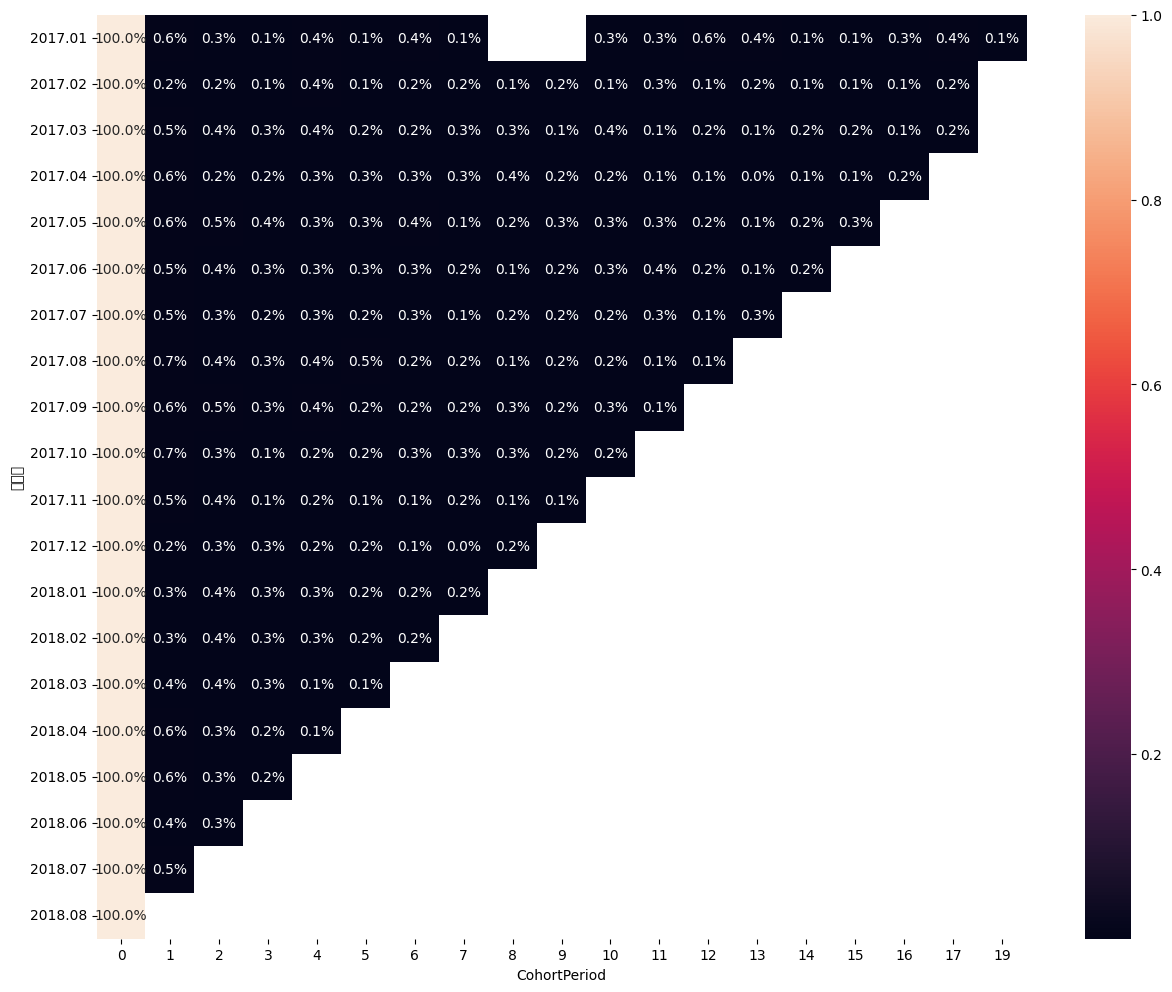

In [442]:
# 전체 기준 코호트 분석
### - 전반적으로 재구매율이 낮구나

co = df[['주문id', 'date', '고객_유니크id', '결제금액_usd']] 
make_cohort_chart(co)

# 2) 가설 및 검증 결과 (T-TEST 분석) 


- #### 가설 : 서비스, 배송 관련 초기 구매 경험이 고객 이탈에 유의미한 영향을 미친다.
- 검증 방식 : T-TEST
    - 두 그룹(이탈/재구매) 간 차이가 유의미한지 보기 위해.

    
 



- 세부 가설 및 검증 결과 :

    - [YES] 이탈고객의 리뷰답변 처리속도가 재구매 고객보다 더 느렸을 것이다. (온라인 만족도)
    - [YES] 이탈고객의 배송소요시간, 물류처리시간, 고객_판매자 간 거리km 등이 재구매 고객보다 더 길었을 것이다. (오프라인 만족도)
    - [YES] 이탈고객의 운임비용이 재구매 고객보다 더 높았을 것이다. (오프라인 만족도)

- 고객 이탈에 유의미한 영향 미치지 않은 것 : 주문처리시간 (p-value 0.7)
- 고객 이탈에 유의미한 영향 미친 것 (유의미한 변수, p-value < 0.05) : 리뷰답변 처리속도 ,   고객_판매자_거리_km  , 배송소요시간, 배송지연시간, 전체물류처리시간, 운임가격

- #### '고객_판매자_거리_km ' : 특히 배송 문제의 근본 원인이 되는 변수
- 이커머스에서 배송은 고객 만족도와 기업 수익성을 크게 좌우하는 주요 요소임 
- #### ∴ 지역별 물류 센터 설치하자! 즉, 고객과 판매자의 거리_km를 줄여 배송 시간 단축하자!

In [18]:
## 이탈 고객 중, 리뷰 작성한 사람 (첫 리뷰!! 첫 구매경험)
one_review = pd.read_csv('/Users/johaneul/Desktop/coding_test/data_analysis/리뷰번역_olist_ecommerce_1번구매고객_2017.csv', index_col=0)
## 재구매 고객 중, 리뷰 작성한 사람 (첫 리뷰!! 첫 구매경험)

purchase_repeat_review = pd.read_csv('/Users/johaneul/Desktop/coding_test/data_analysis/리뷰번역_olist_ecommerce_재구매고객_2017.csv', index_col=0)

/var/folders/32/kf__h26s36l08d_ty7fh2xjr0000gn/T/ipykernel_2580/2612872354.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  one_review = pd.read_csv('/Users/johaneul/Desktop/coding_test/data_analysis/리뷰번역_olist_ecommerce_1번구매고객_2017.csv', index_col=0)


In [19]:
churn_mg =  pd.merge(Churned_Customer_df, one_review[[ '고객_유니크id','리뷰내용_한국어번역']], left_on = ['고객_유니크id'], right_on = ['고객_유니크id'], how='left')
repeat_mg = pd.merge(Repeat_Customer_df, purchase_repeat_review[[ '고객_유니크id','주문id','리뷰내용_한국어번역']], left_on = ['고객_유니크id','주문id'], right_on = ['고객_유니크id','주문id'], how='left')
 # 추가 번역.. 일단 보류
 
print(len(churn_mg[(churn_mg[ '리뷰내용'].notnull()) & (churn_mg[ '리뷰내용_한국어번역'].isnull()) ] ))
print(len(repeat_mg[(repeat_mg[ '리뷰내용'].notnull()) & (repeat_mg[ '리뷰내용_한국어번역'].isnull()) ]))

5865
887


In [20]:
print(churn_mg['고객_유니크id'].nunique(), repeat_mg['고객_유니크id'].nunique())

53436 1977


- 이탈고객 vs 재구매 고객 :: 첫 경험 비교 ::: 리뷰 분석도 비교

 

- 가설 1: 첫 구매 경험이 재구매 여부에 영향을 미친다

-   세부 가설:
    - 재구매 고객은 이탈 고객에 비해 초기 구매 시 배송 시간이 짧았을 것이다.


In [21]:
### 이탈고객 (첫 경험)
'''
최종 순서:
주문처리시간
배송소요시간
배송지연시간
전체물류처리시간
이 순서에 따라 각 단계가 진행되며, 물류 프로세스의 효율성 및 지연 여부를 평가할 수 있습니다
'''

churn_mg[[  '리뷰답변_처리속도', '주문처리시간',  '배송소요시간', '배송지연시간',  '전체물류처리시간', 
 '운임가격_usd' ,'고객_판매자_거리_km']].describe().T[['mean',	'std'	,'min','max']].T
# , '제품_설명길이', '제품_사진수'

,리뷰답변_처리속도,주문처리시간,배송소요시간,배송지연시간,전체물류처리시간,운임가격_usd,고객_판매자_거리_km
mean,2.812012,0.266893,9.649104,-11.981965,12.691098,5.939951,623.947203
std,12.061253,0.801438,9.237575,10.144383,9.998586,4.387658,598.907542
min,0.000000,0.000000,-17.000000,-140.000000,-7.000000,0.000000,0.000000
max,518.000000,60.000000,205.000000,188.000000,208.000000,98.557994,5338.619521


In [22]:
repeat_mg_first = pd.DataFrame(repeat_mg.groupby([ '고객_유니크id'])['구매시간'].min()).reset_index()
repeat_mg_first = pd.merge(repeat_mg_first, repeat_mg, left_on = ['고객_유니크id', '구매시간'], right_on =  ['고객_유니크id', '구매시간'], how='left').drop_duplicates()

## 재구매 고객 (첫 경험)
repeat_mg_first[['리뷰답변_처리속도', '주문처리시간',  '배송소요시간', '배송지연시간',  '전체물류처리시간',  
 '운임가격_usd' ,'고객_판매자_거리_km']].describe().T[['mean',	'std'	,'min','max']].T

,리뷰답변_처리속도,주문처리시간,배송소요시간,배송지연시간,전체물류처리시간,운임가격_usd,고객_판매자_거리_km
mean,2.307577,0.272955,8.257833,-12.668207,11.031330,5.674114,549.160194
std,7.869239,0.793900,7.323552,8.881360,8.171941,3.857166,540.369587
min,0.000000,0.000000,0.000000,-71.000000,-3.000000,0.000000,0.121756
max,204.000000,12.000000,65.000000,47.000000,88.000000,45.764890,3291.983690


In [23]:
from scipy import stats

# 재구매 고객과 이탈 고객의 배송소요시간을 분리 
for t in ['리뷰답변_처리속도', '주문처리시간',  '배송소요시간', '배송지연시간',  '전체물류처리시간', 
 '운임가격_usd' ,'고객_판매자_거리_km']:
    # 독립 표본 t-검정
    t_stat, p_value = stats.ttest_ind(repeat_mg_first[repeat_mg_first[t].notnull()][t], churn_mg[churn_mg[t].notnull()][t], equal_var=False )

    print(f"{t} , T-Statistic: {t_stat}, P-Value: {p_value}")
 

리뷰답변_처리속도 , T-Statistic: -2.7455440602750083, P-Value: 0.0060870494410759785
주문처리시간 , T-Statistic: 0.3346813287846356, P-Value: 0.7378982243763642
배송소요시간 , T-Statistic: -8.147322502478936, P-Value: 6.196586498107428e-16
배송지연시간 , T-Statistic: -3.3303988633747843, P-Value: 0.0008819645228035389
전체물류처리시간 , T-Statistic: -8.724849449679379, P-Value: 5.212307138050957e-18
운임가격_usd , T-Statistic: -3.006095690500559, P-Value: 0.002676377648677815
고객_판매자_거리_km , T-Statistic: -6.01960590388467, P-Value: 2.0490572350753944e-09


In [153]:
churn_mg[[ '평점', '제품가격_usd','결제금액_usd', '제품_설명길이', '제품_사진수']].describe().T[['mean',	'std'	,'min','max']].T

,리뷰답변_처리속도,평점,제품가격_usd,결제금액_usd,제품_설명길이,제품_사진수
mean,2.812012,4.071854,38.031135,47.381098,773.089020,2.247144
std,12.061253,1.344972,57.625006,66.202476,653.314421,1.741354
min,0.000000,1.000000,0.376176,0.003135,4.000000,1.000000
max,518.000000,5.000000,2111.285266,4283.410658,3992.000000,20.000000


In [24]:

## 재구매 고객 (초기 경험)
repeat_mg_first[[ '리뷰답변_처리속도','평점', '제품가격_usd','결제금액_usd', '제품_설명길이', '제품_사진수']].describe().T[['mean',	'std'	,'min','max']].T

,리뷰답변_처리속도,평점,제품가격_usd,결제금액_usd,제품_설명길이,제품_사진수
mean,2.307577,4.241846,33.189988,44.491914,764.949824,2.11139
std,7.869239,1.242130,41.734421,52.036397,650.040291,1.63042
min,0.000000,1.000000,1.536050,0.024658,31.000000,1.00000
max,204.000000,5.000000,815.047022,823.219436,3939.000000,15.00000


In [157]:
from scipy import stats

# 재구매 고객과 이탈 고객의 배송소요시간을 분리 
for t in [ '리뷰답변_처리속도','평점', '제품가격_usd','결제금액_usd',  '제품_설명길이', '제품_사진수']:
    # 독립 표본 t-검정
    t_stat, p_value = stats.ttest_ind(repeat_mg_first[repeat_mg_first[t].notnull()][t], churn_mg[churn_mg[t].notnull()][t] , equal_var=False)

    print(f"{t} , T-Statistic: {t_stat}, P-Value: {p_value}")
 

리뷰답변_처리속도 , T-Statistic: -2.7455440602750083, P-Value: 0.0060870494410759785
평점 , T-Statistic: 5.981998192059213, P-Value: 2.571631630818435e-09
제품가격_usd , T-Statistic: -5.005979499935355, P-Value: 5.983051212743944e-07
결제금액_usd , T-Statistic: -2.4080358593904108, P-Value: 0.01611909090671165
제품_설명길이 , T-Statistic: -0.5488739265761163, P-Value: 0.5831491612529967
제품_사진수 , T-Statistic: -3.6415019617925126, P-Value: 0.00027742263764770784


# 3) 가설 및 검증 결과 (고객 리뷰 긍부정 분석) 


- #### 가설 : 제품, 배송, 사이트 관련 부정적 초기 경험이 고객 이탈에 영향을 미친다.
- 검증 방식 : 리뷰 긍부정 비교 분석 
- 형태소 분석을 기반으로 명사, 형용사 추출 -> '제품', '배송'등 주요 키워드별 n-gram 분석 -> 긍·부정 태깅   -> 부정적 단어 빈도(%) 비교: 이탈 고객 vs 재구매 고객
    - (리뷰 분석 이유) 고객의 온오프라인 경험, 특히 ‘제품’에 대한 고객 경험도 더 깊게 파악하기 위해. 



- 세부 가설 및 검증 결과 :

    - [YES] 이탈고객은 재구매 고객보다 제품'품질'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 제품'마감'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 '배송'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 '사이트'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 사이트'구매'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)



# 위 부분은 다음 notebook에 정리됨. 

-to be continued- 